In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/titanic/train.csv')

In [3]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Deleting many features and trying to fit the rest

In [4]:
df['Sex'] = df['Sex'].replace('male', 1)
df['Sex'] = df['Sex'].replace('female', 0)


cleaned_df = df.drop('Ticket', axis=1)
# Replacing Nan with the mean
mean_age = cleaned_df['Age'].mean()
cleaned_df['Age'] = cleaned_df['Age'].fillna(mean_age)

cleaned_df = cleaned_df.drop('Cabin', axis=1)
cleaned_df = cleaned_df.drop('Embarked', axis=1)
cleaned_df = cleaned_df.drop('Name', axis=1)
cleaned_df = cleaned_df.drop('PassengerId', axis=1)

In [5]:
print(cleaned_df.isnull().any())


Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
dtype: bool


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

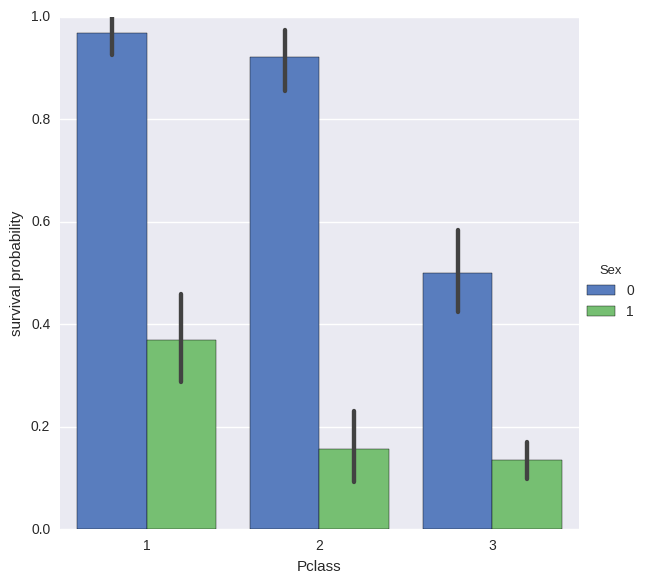

In [7]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=cleaned_df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")
plt.show()

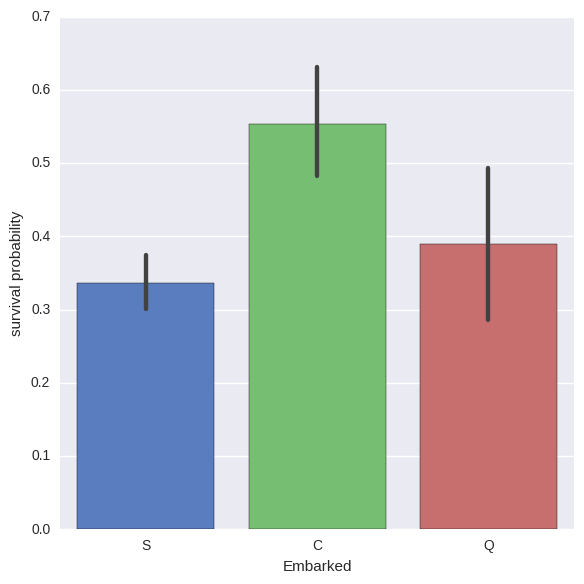

In [8]:
g = sns.factorplot(x="Embarked", y="Survived", data=df,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")
plt.show()

As we see from the graph, women tend to survive more

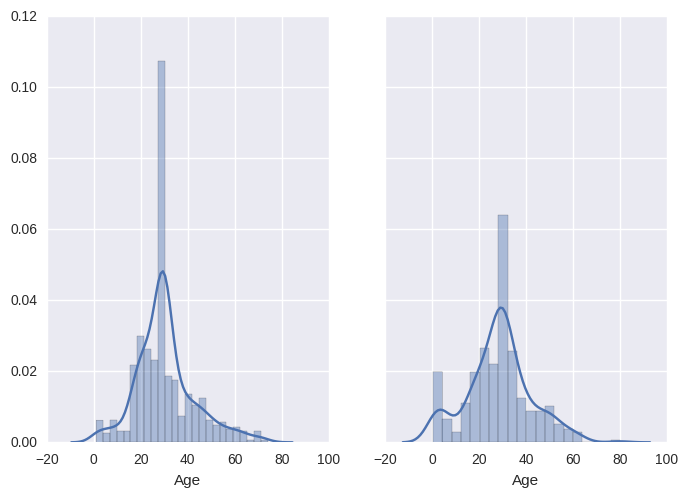

In [9]:
#print(cleaned_df[cleaned_df["Survived"] == 0]['Age'])
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.distplot(cleaned_df[cleaned_df["Survived"] == 0]['Age'], ax=ax1)
sns.distplot(cleaned_df[cleaned_df["Survived"] == 1]['Age'], ax=ax2)
ax1.set_label('Not survived')
ax2.set_label('Survived')

plt.show()

Children more or less tend to survive

# Random forest


In [10]:
from sklearn.ensemble import RandomForestClassifier
y = cleaned_df['Survived']
X = cleaned_df.drop('Survived', axis=1)

In [11]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from time import time


def train_random_forest(X, y):
    '''
    Tries to find best params by random search and train the model
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=20)
    param_dist = {"max_depth": [5, 10, 50, 100, 500, 1000, 1500, 2000, 3000, 5000, 8000, 10000],
                  "max_features": sp_randint(1, X.shape[1]),
                  "min_samples_split": sp_randint(2, 11),
                  "min_samples_leaf": sp_randint(1, 11),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    n_iter_search = 100
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                       n_iter=n_iter_search)

    def report(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")

    start = time()
    random_search.fit(X, y)
    # print("RandomizedSearchCV took %.2f seconds for %d candidates"
    #       " parameter settings." % ((time() - start), n_iter_search))
    # report(random_search.cv_results_)
    
    results = random_search.cv_results_
    candidates = np.flatnonzero(results['rank_test_score'] == 1)
    best = results['params'][candidates[0]]
    # clf = RandomForestClassifier(n_estimators=20, **best)

    # clf.fit(X_train, y_train)
    # print("Accuracy on the test set: {0}".format(clf.score(X_test, y_test)))
    print('Best params: {0}'.format(best))
    clf = RandomForestClassifier(n_estimators=20, **best)
    scores = cross_val_score(clf, X, y, cv=30)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    

In [12]:
train_random_forest(X,y)

Best params: {'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': 8000, 'min_samples_leaf': 2, 'max_features': 2, 'bootstrap': False}
Accuracy: 0.83 (+/- 0.13)


# More complex features

In [13]:


cleaned_df_1 = df.drop('Ticket', axis=1)
mean_age = cleaned_df_1['Age'].mean()
cleaned_df_1['Age'] = cleaned_df_1['Age'].fillna(-1)

cleaned_df_1 = cleaned_df_1.drop('Name', axis=1)
cleaned_df_1 = cleaned_df_1.drop('PassengerId', axis=1)

#
#cleaned_df = cleaned_df.drop('Embarked', axis=1)


In [14]:
cleaned_df_1['Number of cabins'] = df['Cabin'].map(lambda x: len(str(x).split(' ')) if not pd.isnull(x) else 0)

In [15]:
cleaned_df_1['Part of the boat'] = df['Cabin'].map(lambda x: x[0] if not pd.isnull(x) else '-1')
cleaned_df_1 = cleaned_df_1.drop('Cabin', axis=1)

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
cleaned_df_1['Part of the boat'] = LabelEncoder().fit_transform(cleaned_df_1['Part of the boat'])

In [18]:
cleaned_df_1['Embarked'] = cleaned_df_1['Embarked'].map(lambda x: str(x))
cleaned_df_1['Embarked'] = LabelEncoder().fit_transform(cleaned_df_1['Embarked'])

In [19]:
cleaned_df_1

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Number of cabins,Part of the boat
0,0,3,1,22.0,1,0,7.2500,2,0,0
1,1,1,0,38.0,1,0,71.2833,0,1,3
2,1,3,0,26.0,0,0,7.9250,2,0,0
3,1,1,0,35.0,1,0,53.1000,2,1,3
4,0,3,1,35.0,0,0,8.0500,2,0,0
5,0,3,1,-1.0,0,0,8.4583,1,0,0
6,0,1,1,54.0,0,0,51.8625,2,1,5
7,0,3,1,2.0,3,1,21.0750,2,0,0
8,1,3,0,27.0,0,2,11.1333,2,0,0
9,1,2,0,14.0,1,0,30.0708,0,0,0


In [20]:
y = cleaned_df_1['Survived']
X = cleaned_df_1.drop('Survived', axis=1)
train_random_forest(X, y)

Best params: {'criterion': 'entropy', 'min_samples_split': 4, 'max_depth': 2000, 'min_samples_leaf': 3, 'max_features': 4, 'bootstrap': True}
Accuracy: 0.82 (+/- 0.15)


In [21]:
cleaned_df_1['Age'] = df['Age'].fillna(-1000)
cleaned_df_1 = cleaned_df_1.drop('Number of cabins', axis=1)

y = cleaned_df_1['Survived']
X = cleaned_df_1.drop('Survived', axis=1)
train_random_forest(X, y)

Best params: {'criterion': 'gini', 'min_samples_split': 3, 'max_depth': 50, 'min_samples_leaf': 4, 'max_features': 6, 'bootstrap': True}
Accuracy: 0.82 (+/- 0.13)


# Adding more features didn't help
This could be because of the model or because these new features aren't representative enough.
Let's try to group continuous features

In [22]:
def grp(x):
    if x < 5:
        return 0
    elif x < 12:
        return 1
    elif x < 18:
        return 2
    elif x < 30:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif pd.isnull(x):
        return -1
    else:
        return 6

cleaned_df_1['Age'] = df['Age'].map(grp)

def grp1(x):
    if x < 10:
        return 1
    elif x < 30:
        return 2
    elif x < 50:
        return 3
    elif x < 70:
        return 4
    else:
        return 5

cleaned_df_1['Fare'] = df['Fare'].map(grp)


In [23]:
cleaned_df_1

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Part of the boat
0,0,3,1,3,1,0,1,2,0
1,1,1,0,4,1,0,6,0,3
2,1,3,0,3,0,0,1,2,0
3,1,1,0,4,1,0,5,2,3
4,0,3,1,4,0,0,1,2,0
5,0,3,1,-1,0,0,1,1,0
6,0,1,1,5,0,0,5,2,5
7,0,3,1,0,3,1,3,2,0
8,1,3,0,3,0,2,1,2,0
9,1,2,0,2,1,0,4,0,0


In [24]:
y = cleaned_df_1['Survived']
X = cleaned_df_1.drop('Survived', axis=1)
train_random_forest(X, y)

Best params: {'criterion': 'gini', 'min_samples_split': 8, 'max_depth': 5000, 'min_samples_leaf': 3, 'max_features': 3, 'bootstrap': True}
Accuracy: 0.81 (+/- 0.15)


In [25]:
dummies = pd.get_dummies(cleaned_df_1, columns=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Part of the boat'])

In [26]:
y = dummies['Survived']
X = dummies.drop('Survived', axis=1)
train_random_forest(X, y)

Best params: {'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 2000, 'min_samples_leaf': 3, 'max_features': 34, 'bootstrap': True}
Accuracy: 0.82 (+/- 0.14)
